# Import Required Libraries

In [1]:
import sys
import os
sys.path.append("../src")

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

In [2]:
# np.random.seed(100)
rho = 0.5
N = 500000
NumberofSources = 5
NumberofMixtures = 10

# NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = True)

INPUT_STD = 0.28
A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)

SNR=30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.99323481420007


# Visualize Generated Sources and Mixtures

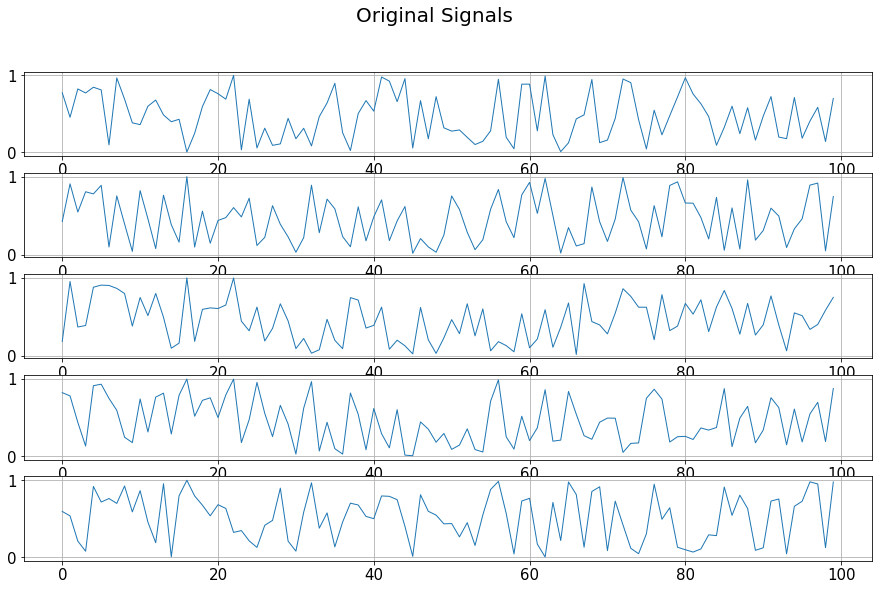

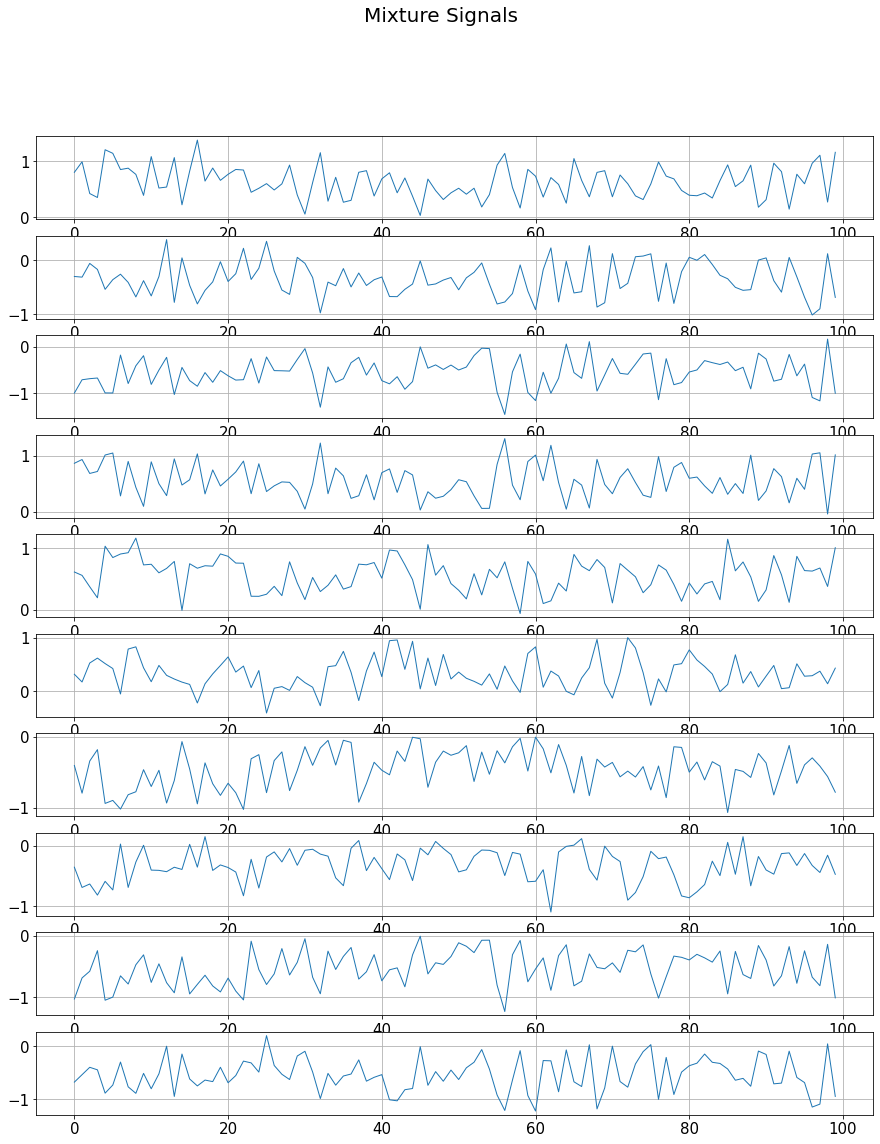

In [3]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
if rho > 0.4:
    gamma_start = 0.05
    gamma_stop = 5*1e-4
else:
    gamma_start = 0.1
    gamma_stop = 1e-3
    
gammaM_start = [gamma_start, gamma_start]
gammaM_stop = [gamma_stop, gamma_stop]
gammaW_start = [gamma_start, gamma_start]
gammaW_stop = [gamma_stop, gamma_stop]

OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1e-3,1e-3]
LayerMaximumGains = [1e6,20]
WScalings = [0.0033,0.0033]
GamScalings = [2,1]
zeta = 1*1e-5
beta = 0.5
muD = [1, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# Run WSM Algorithm on Mixture Signals

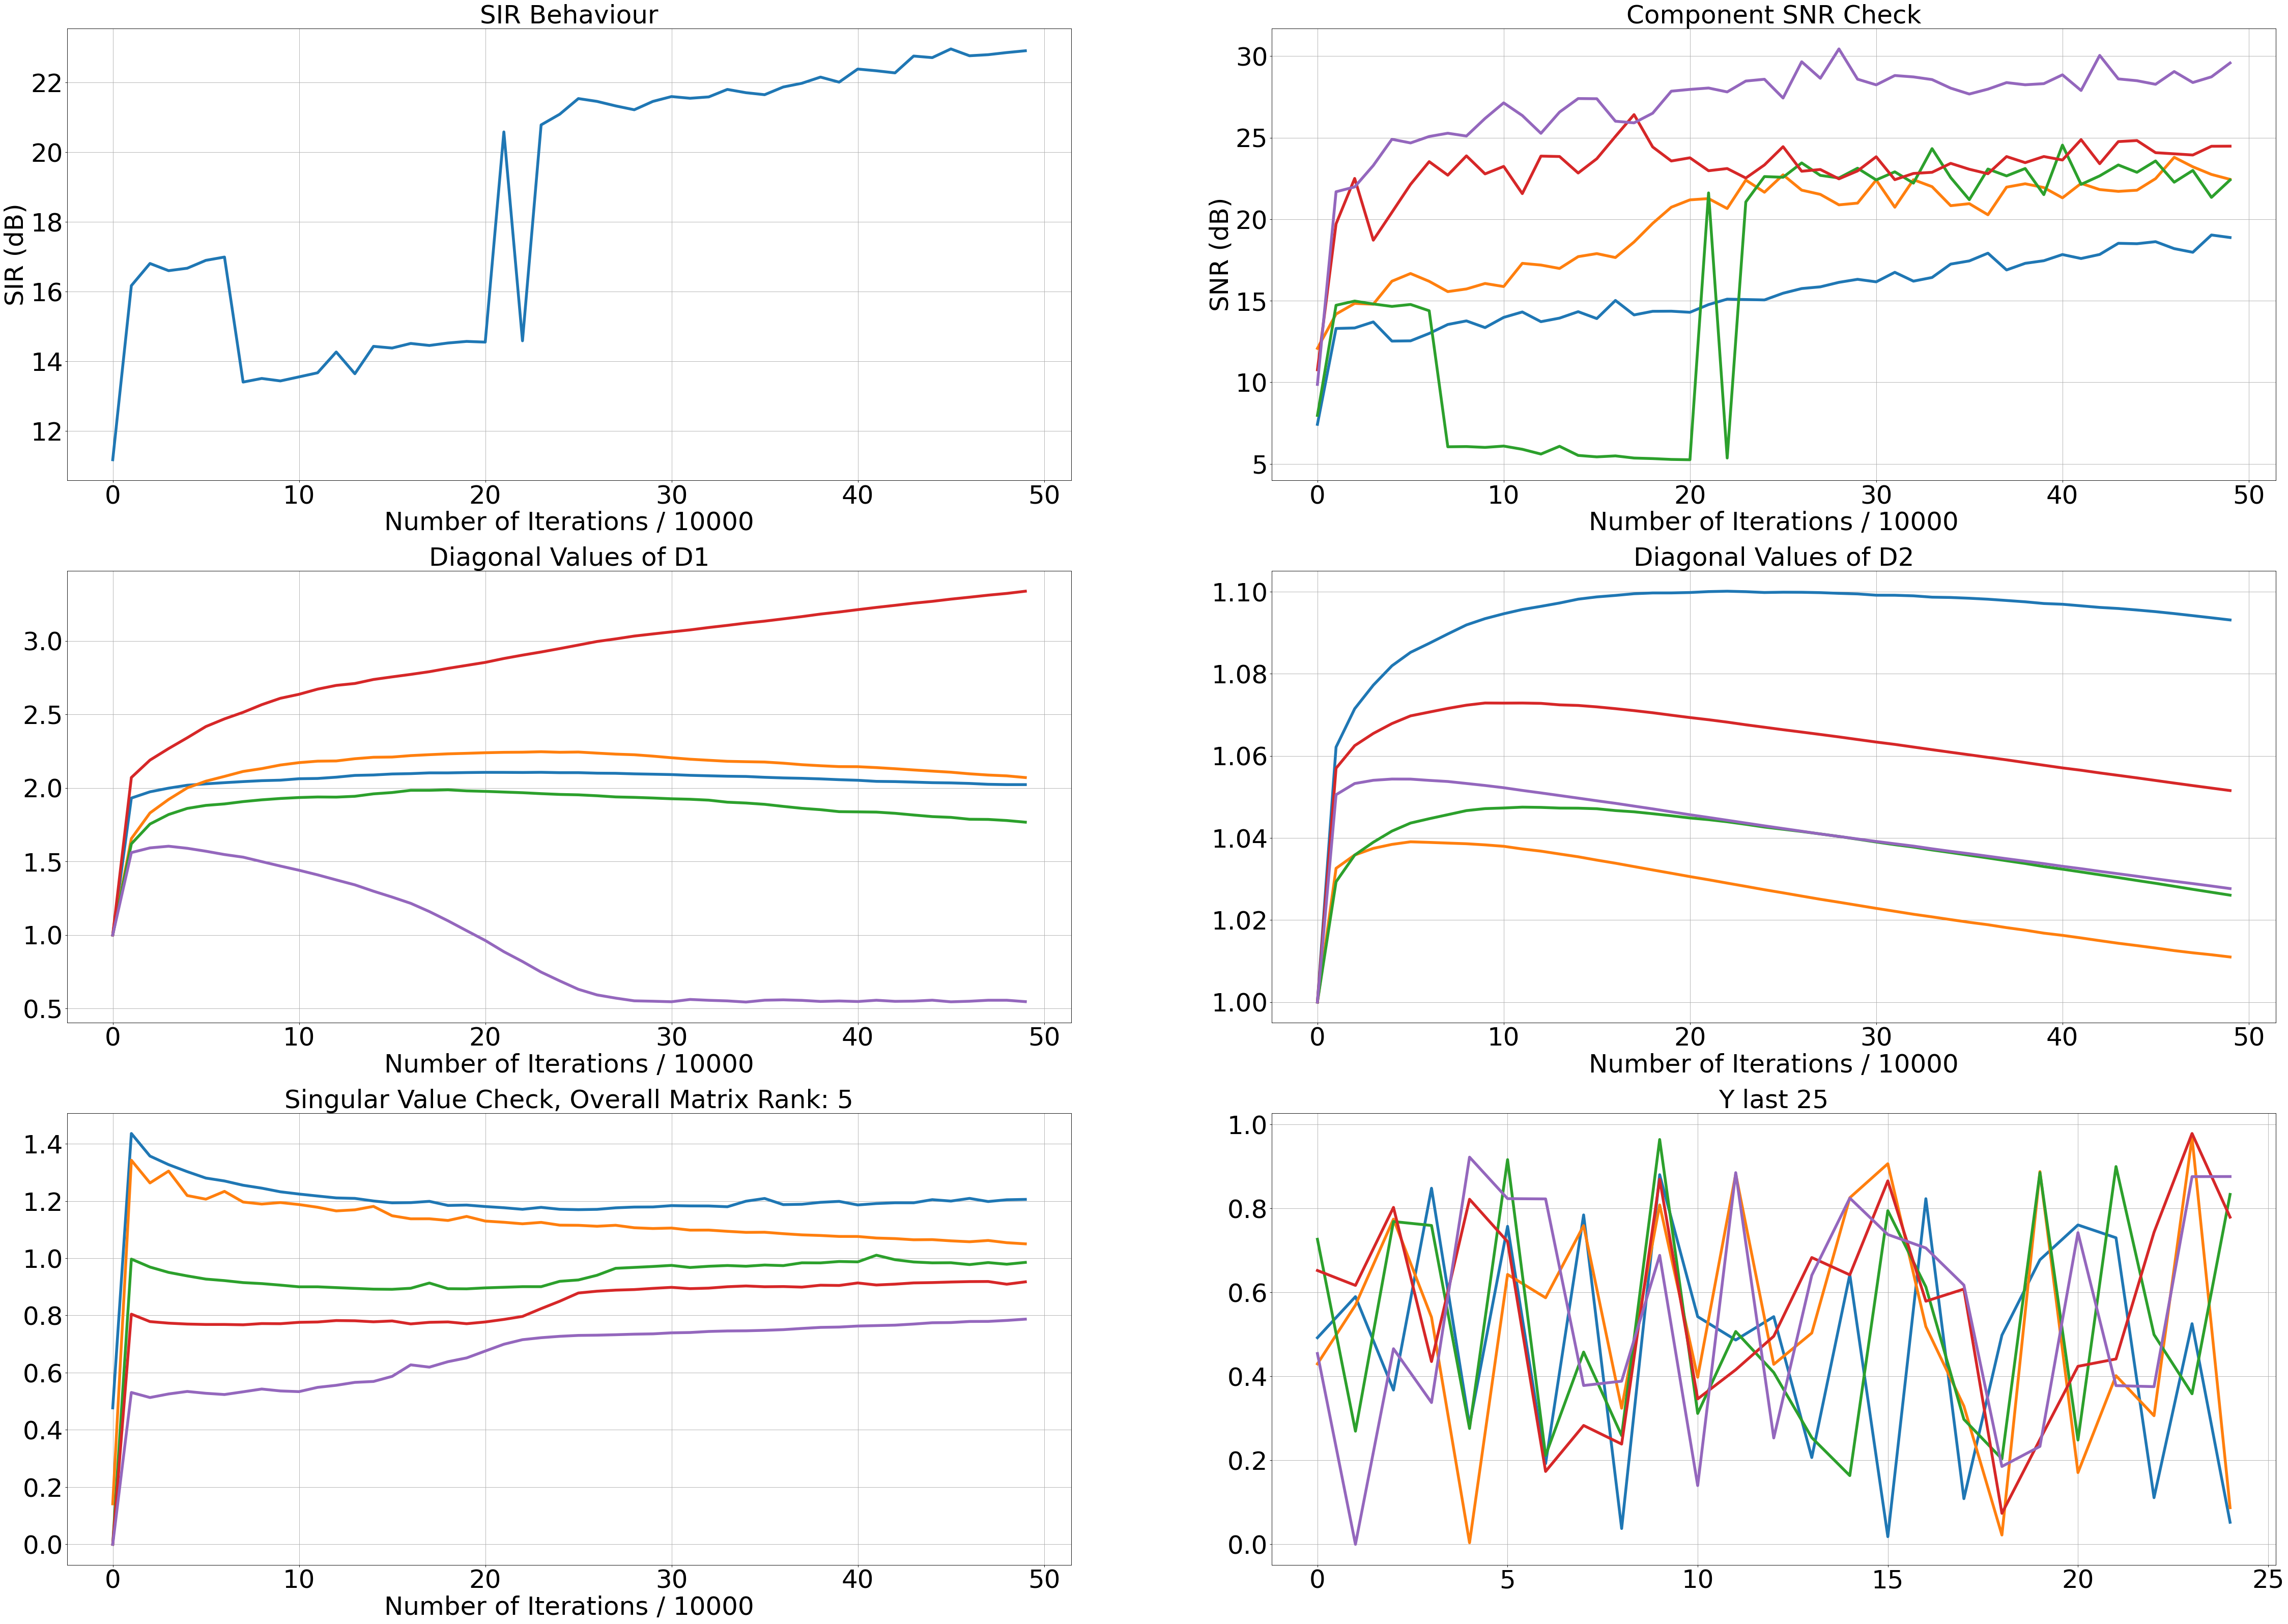

100%|██████████| 500000/500000 [28:13<00:00, 295.25it/s]


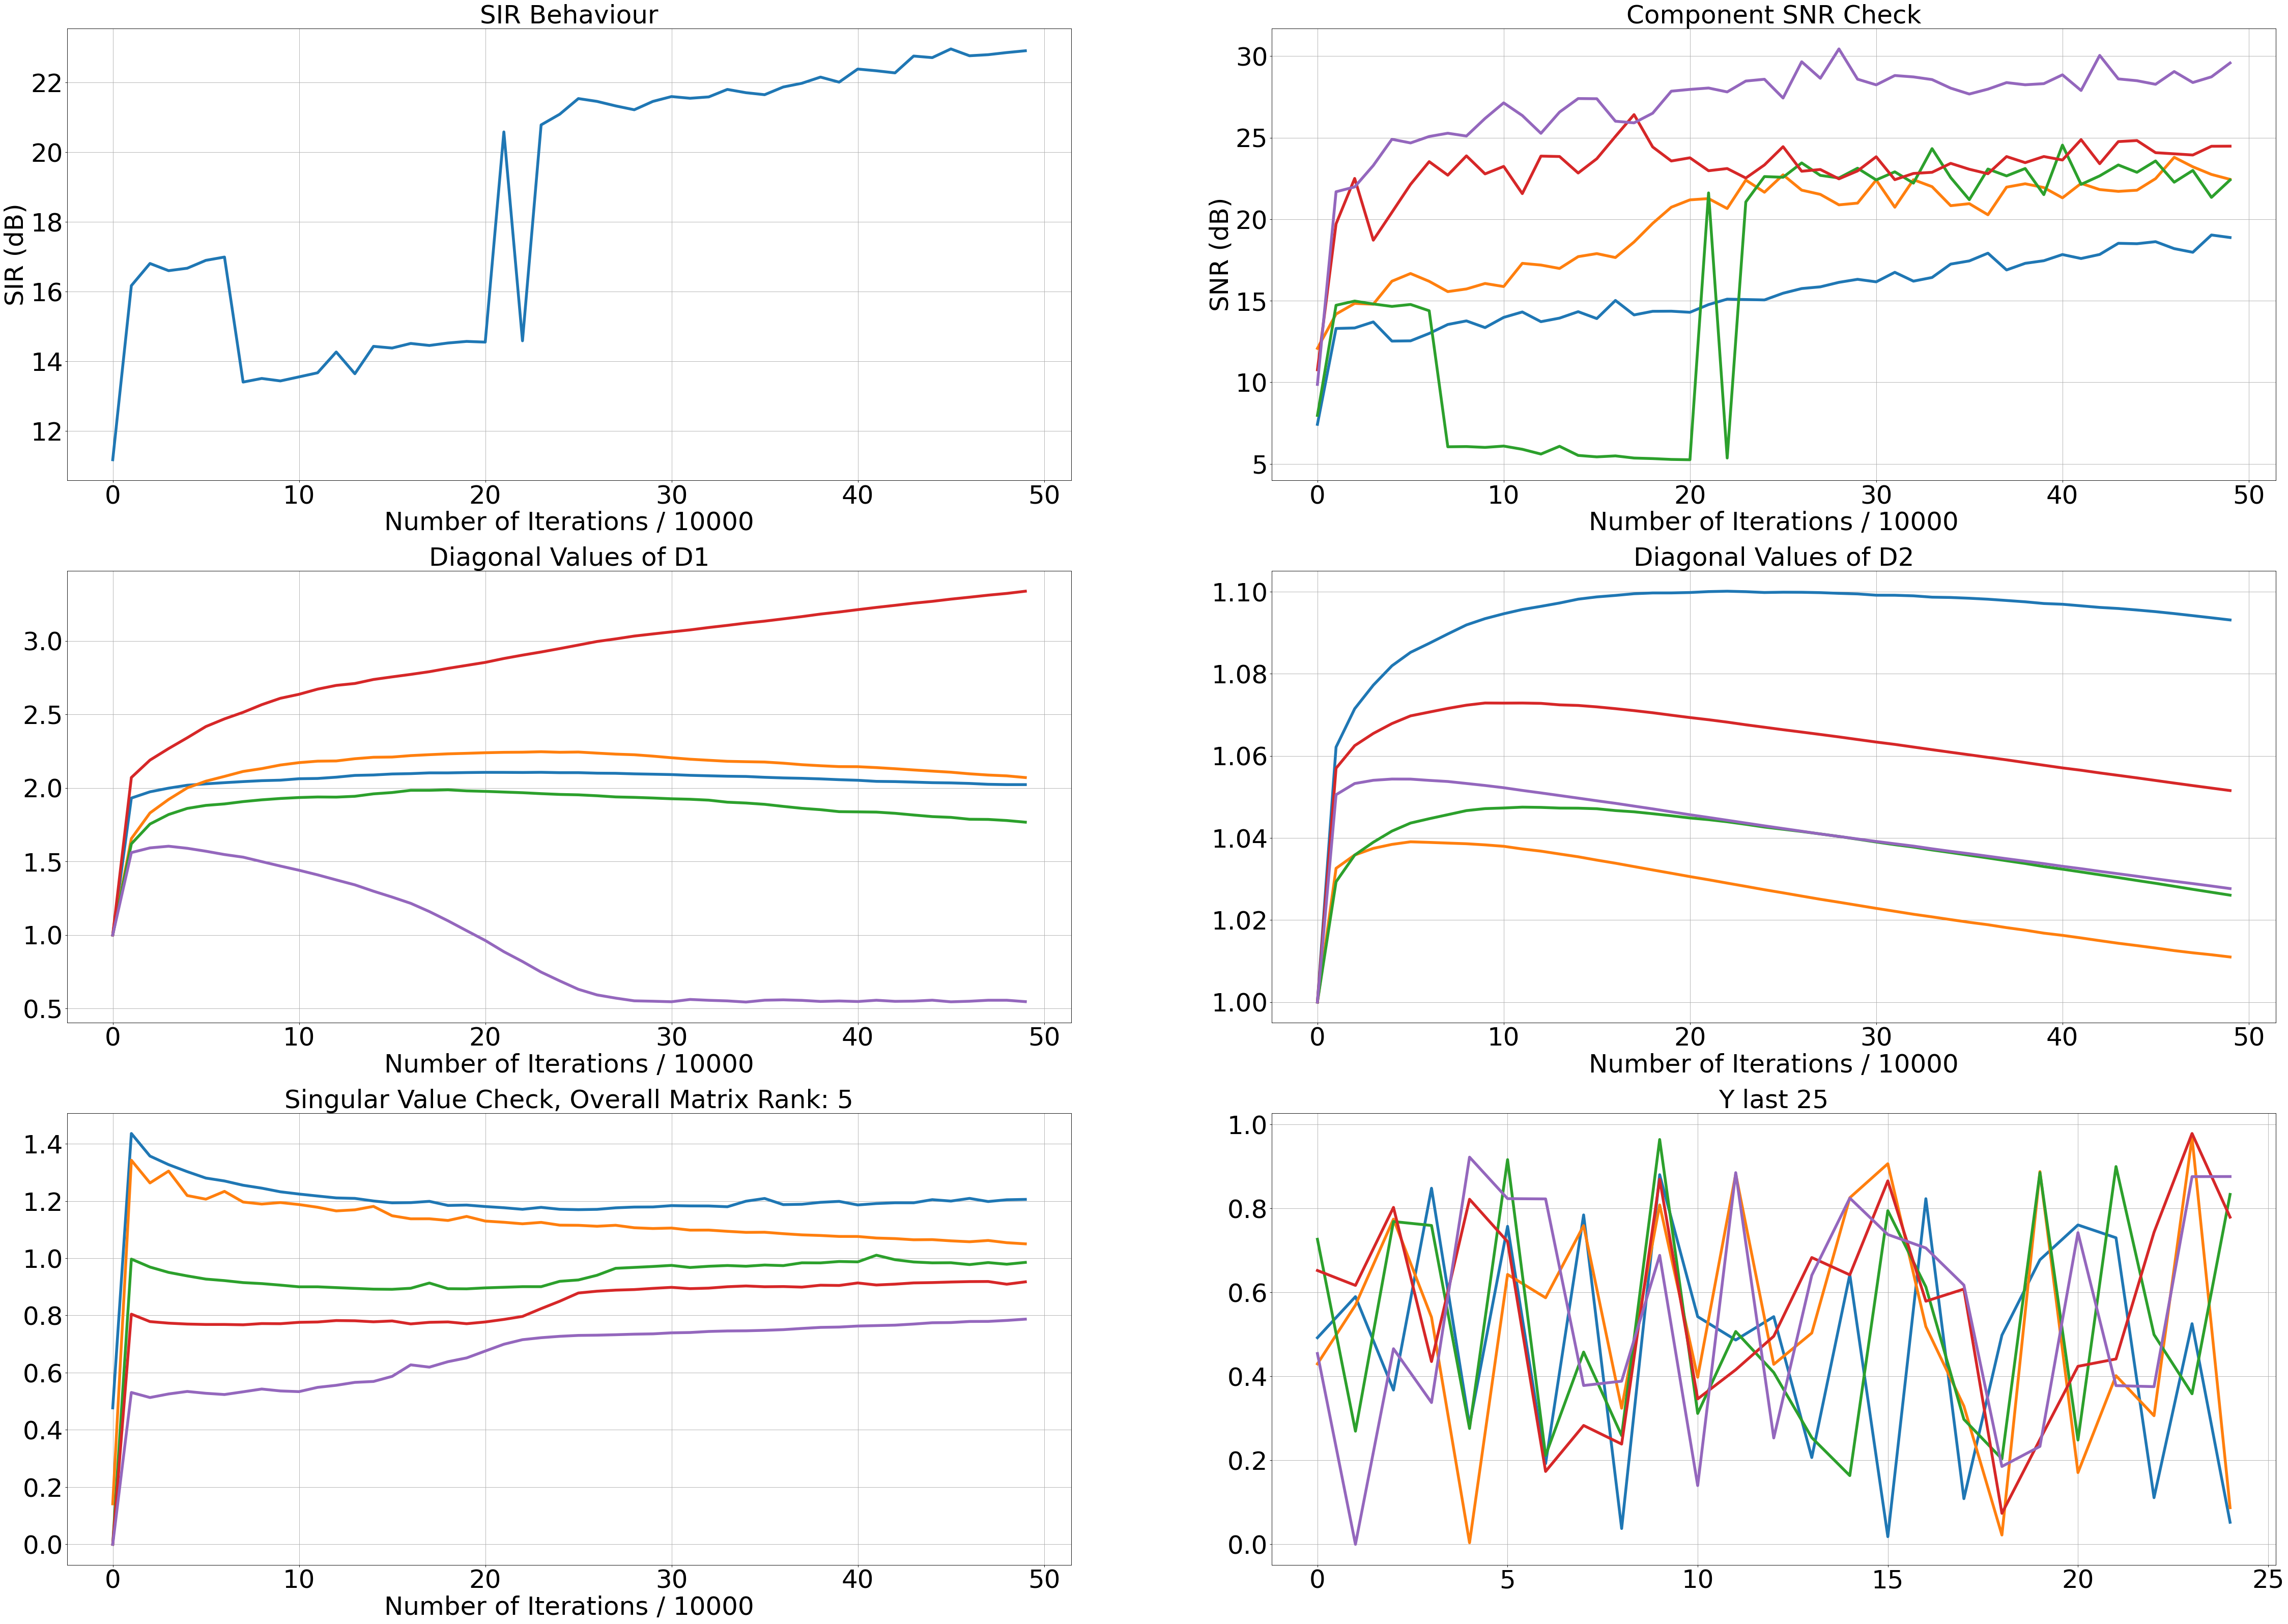

In [5]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gammaM_start = gammaM_start, gammaM_stop = gammaM_stop, 
                         gammaW_start = gammaW_start, gammaW_stop = gammaW_stop, 
                         beta = beta, zeta = zeta,  
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = -W_HX, W_YH = -W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_nnantisparse( X, n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = 0.75,
                                 neural_lr_stop = 0.05,
                                 synaptic_lr_decay_divider = 1,
                                 neural_lr_decay_multiplier = 0.005,
                                 hidden_layer_gain = 100,
                                 shuffle = False,
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True,
                                )

In [6]:
# debug_iteration_point = 25000
# modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
#                          gammaM_start = gammaM_start, gammaM_stop = gammaM_stop, 
#                          gammaW_start = gammaW_start, gammaW_stop = gammaW_stop, 
#                          beta = beta, zeta = zeta,  
#                          muD = muD,WScalings = WScalings, GamScalings = GamScalings,
#                          W_HX = W_HX, W_YH = W_YH,
#                          DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
#                          LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
#                          set_ground_truth = True, S = S, A = A)

In [7]:
# neural_dynamic_iterations = 500
# neural_lr_start = 0.75
# neural_lr_stop = 0.05
# OUTPUT_COMP_TOL = 1e-5
# neural_lr_rule = "divide_by_slow_loop_index"
# lr_decay_multiplier = 0.005
# hidden_layer_gain = 200
# W_HX = -modelWSM.W_HX
# W_YH = modelWSM.W_YH
# M_H = modelWSM.M_H
# M_Y = modelWSM.M_Y
# D1 = modelWSM.D1
# D2 = modelWSM.D2

# H = np.zeros((h_dim,samples))
# Y = np.zeros((s_dim,samples))

# i_sample = 97

# x_current  = X[:,i_sample] # Take one input
# y = Y[:,i_sample]
# h = H[:,i_sample]

# modelWSM.run_neural_dynamics_nnantisparse_jit(x_current, h, y, M_H, M_Y, W_HX, W_YH, D1, D2, beta, zeta, 
#                                              neural_dynamic_iterations, neural_lr_start, neural_lr_stop, 
#                                              neural_lr_rule, lr_decay_multiplier, hidden_layer_gain, 
#                                              True, OUTPUT_COMP_TOL)

In [8]:
debug_iteration_point = 25000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gammaM_start = gammaM_start, gammaM_stop = gammaM_stop, 
                         gammaW_start = gammaW_start, gammaW_stop = gammaW_stop, 
                         beta = beta, zeta = zeta,  
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = W_HX, W_YH = W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)


In [9]:
modelWSM.compute_overall_mapping(return_mapping = True)

array([[0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [10]:
modelWSM.fit_batch_nnantisparse( X[:,[0,1]].reshape(-1,2), n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = 0.75,
                                 neural_lr_stop = 0.05,
                                 synaptic_lr_decay_divider = 1,
                                 neural_lr_decay_multiplier = 0.005,
                                 hidden_layer_gain = 100,
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = False,
                                )

100%|██████████| 2/2 [00:10<00:00,  5.19s/it]

operands could not be broadcast together with shapes (2,5,1) (500000,1,5) 


<Figure size 5600x4000 with 0 Axes>

In [11]:
modelWSM.neural_OUTPUT_COMP_TOL

1e-07

In [12]:
modelWSM.M_H

array([[ 1.82032834e+00, -2.30299130e-03, -6.29937991e-03,
         9.12580091e-03,  5.94330404e-03],
       [-2.30299130e-03,  1.81174084e+00,  1.61946895e-03,
        -2.30442701e-03, -1.51108184e-03],
       [-6.29937991e-03,  1.61946895e-03,  1.81580261e+00,
        -6.37559229e-03, -4.23935552e-03],
       [ 9.12580091e-03, -2.30442701e-03, -6.37559229e-03,
         1.82027552e+00,  5.96720197e-03],
       [ 5.94330404e-03, -1.51108184e-03, -4.23935552e-03,
         5.96720197e-03,  1.81508732e+00]])

In [13]:
modelWSM.compute_overall_mapping(return_mapping = True)

array([[ 0.34193635, -0.00382452, -0.01040404,  0.00853264,  0.00553362,
         0.00250293, -0.00666134, -0.00580196, -0.00896296, -0.00637725],
       [-0.00215257,  0.33401861,  0.00189174, -0.0021477 , -0.00140327,
        -0.00064835,  0.00163429,  0.00142435,  0.00230112,  0.00162504],
       [-0.00592075,  0.00191443,  0.33880175, -0.005981  , -0.00396784,
        -0.00191467,  0.00431252,  0.00376391,  0.00667959,  0.00464753],
       [ 0.00857888, -0.00383248, -0.01055296,  0.34187877,  0.00557201,
         0.00256131, -0.00655134, -0.00570877, -0.00911211, -0.00644777],
       [ 0.00560148, -0.00251759, -0.00703554,  0.00560957,  0.33701547,
         0.00172566, -0.00420323, -0.00366482, -0.00609164, -0.00428203]])

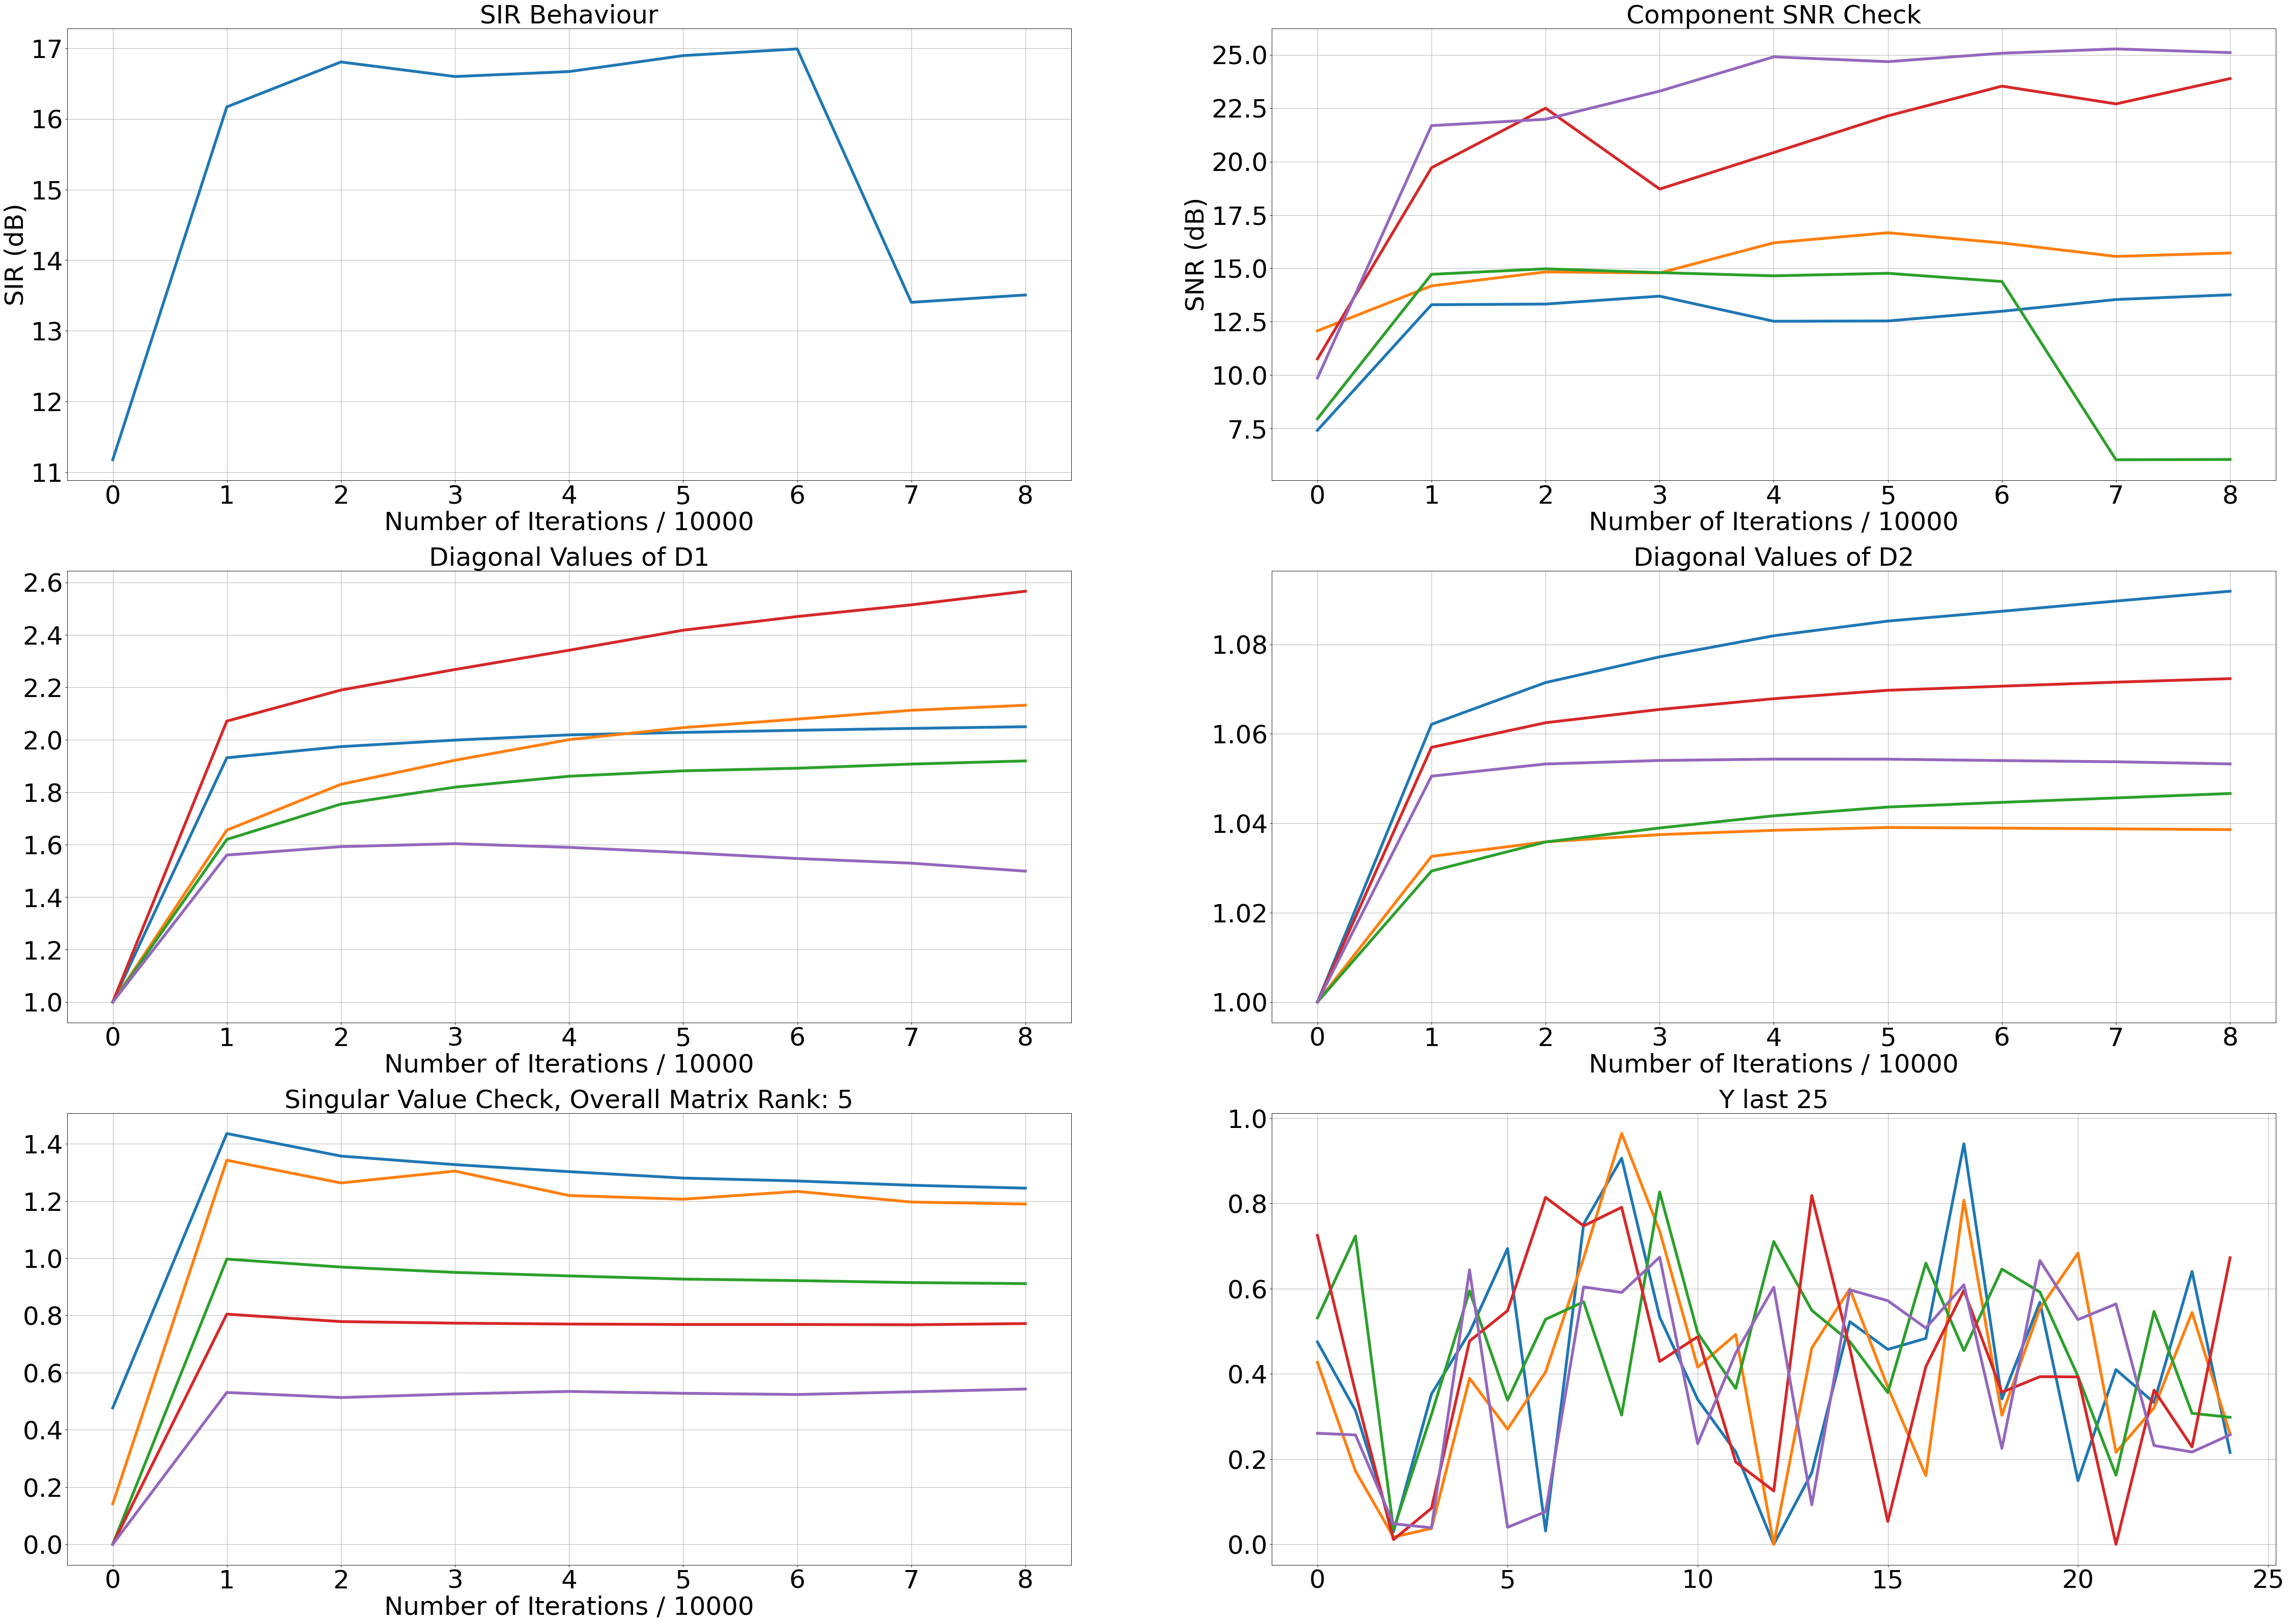

 16%|█▌        | 80042/500000 [03:59<3:48:54, 30.58it/s]

In [ ]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gammaM_start = gammaM_start, gammaM_stop = gammaM_stop, 
                         gammaW_start = gammaW_start, gammaW_stop = gammaW_stop, 
                         beta = beta, zeta = zeta,  
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = -W_HX, W_YH = -W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_nnantisparse( X, n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = 0.75,
                                 neural_lr_stop = 0.05,
                                 synaptic_lr_decay_divider = 1,
                                 neural_lr_decay_multiplier = 0.005,
                                 hidden_layer_gain = 100,
                                 shuffle = False,
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True,
                                )

# Visualize SNR Convergence of Each Source Component

In [ ]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)